In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import importlib
import numpy as np
import xarray as xr
import basin_masks
import streamfunction
import matplotlib.pyplot as plt

import ecco_v4_py as ecco

SETUP TO ACCESS THE VOLUME FLUX FILES 
1. Download 'Google Drive app' and login with your account that has access to GTC
2. Create a shortcut from the GTC folder in 'My Drive'
3. Go to File Explorer on your local computer (search for G:// or H:// ...) and navigate to the shortcut
4. Copy this filepath and replace it where it says 'DIR'

In [3]:
# Change this to your local Drive dir
DIR = "/Users/emiliolr/Google Drive/My Drive/GTC/"
DATA_DIR = DIR + "solodoch_data_full/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4"

In [4]:
# Load the geom_fp file -- this might also need to be changed to where you have this locally!
geom_fp = DIR + 'utility_files/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'
user_home_dir = os.getcwd()
sys.path.append(os.path.join(user_home_dir, "ECCOv4-py"))
ECCO_dir = os.path.join(user_home_dir,geom_fp)
ecco_grid = xr.open_dataset(ECCO_dir)

In [5]:
## Load ECCO variables
nc_files = (os.path.join(DATA_DIR, '*.nc'))
ds = xr.open_mfdataset(nc_files, data_vars='minimal',coords='minimal',compat='override')

# Merge the Volume Flux and grid file into one dataset
ds = xr.merge((ds, ecco_grid))
ds

<xarray.Dataset>
Dimensions:    (tile: 13, j_g: 90, i_g: 90, k_p1: 51, k_l: 50, j: 90, i: 90,
                time: 312, k: 50, nb: 4, k_u: 50, nv: 2)
Coordinates: (12/24)
    XG         (tile, j_g, i_g) float32 -115.0 -115.0 -115.0 ... -102.9 -109.0
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    YC         (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    XC         (tile, j, i) float32 -111.6 -111.3 -110.9 ... -105.6 -111.9
    YG         (tile, j_g, i_g) float32 -88.18 -88.32 -88.46 ... -87.99 -88.02
    ...         ...
  * k_p1       (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * nb         (nb) float32 0.0 1.0 2.0 3.0
  * nv         (nv) float32 0.0 1.0
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables: (12/24)
    VVELMASS   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    WVELMASS   (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    UVELMASS   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    CS         (tile, j, i) float32 ...
    SN         (tile, j, i) float32 ...
    rA         (tile, j, i) float32 ...
    ...         ...
    hFacC      (k, tile, j, i) float32 ...
    hFacW      (k, tile, j, i_g) float32 ...
    hFacS      (k, tile, j_g, i) float32 ...
    maskC      (k, tile, j, i) bool ...
    maskW      (k, tile, j, i_g) bool ...
    maskS      (k, tile, j_g, i) bool ...
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Three-Dimensional Volume Flux...
    uuid:                            54fde4fa-4181-11eb-807f-0cc47a3f8057
    history_json:                    [{"$schema":"https:\/\/harmony.earthdata...

## STREAMFUNCTION UTILS

-- All functions needed to calculate the streamfunction (deduced from ecco)

In [30]:
def parse_coords(ds, coords, coordlist):
    if coords is not None:
        return coords
    else:
        for f in set(["maskW", "maskS"]).intersection(ds.reset_coords().keys()):
            coordlist.append(f)

        if "time" in ds.dims:
            coordlist.append("time")

        dsout = ds[coordlist]
        if "domain" in ds.attrs:
            dsout.attrs["domain"] = ds.attrs["domain"]
        return dsout

In [31]:
def initialize_section_trsp_data_array(coords):
    xda = xr.zeros_like(coords["k"])
    xda = (
        xda if "time" not in coords.dims else xda.broadcast_like(coords["time"]).copy()
    )

    # Convert to dataset to add Z coordinate
    xds = xda.to_dataset(name="trsp_z")
    xds["Z"] = coords["Z"]
    xds = xds.set_coords("Z")

    return xds

In [33]:
def volume_transport_calc(ds, maskS, maskW):

    # Setup the grid system and multiply the values with the grid cell width and height
    coords = parse_coords(ds, None, ["Z", "XC", "YC", "drF", "dyG", "dxG"])
    x_vol = ds["UVELMASS"] * coords["drF"] * coords["dyG"]
    y_vol = ds["VVELMASS"] * coords["drF"] * coords["dxG"]

    # Initialize data output
    #coords = coords if coords is not None else x_vol.to_dataset(name="yfld")
    ds_out = initialize_section_trsp_data_array(coords)

    # Calculate the meridional transport 
    sec_trsp_y = (y_vol* maskS).sum(dim=["i", "j_g", "tile"])
    sec_trsp_x = (x_vol * maskW).sum(dim=["i_g", "j", "tile"])
    return ds_out, sec_trsp_x, sec_trsp_y

In [34]:
def calc_streamfunction_from_volume_transport(ds_out, flip=True):

    # Convert to sverdrups 
    METERS_CUBED_TO_SVERDRUPS = 10**-6

    psi_moc = ds_out["trsp_z"].copy(deep=True)
    
    # Calculate the cumulative sum over depth (flip depths if necessary)
    if flip:
        psi_moc = psi_moc.isel(k=slice(None, None, -1))
    psi_moc = psi_moc.cumsum(dim="k")
    if flip:
        psi_moc = -1 * psi_moc.isel(k=slice(None, None, -1))
    ds_out["psi_moc"] = psi_moc

    ds_out["moc"] = ds_out["psi_moc"].max(dim="k")

    for fld in ["trsp_z", "psi_moc", "moc"]:
        converted = (ds_out[fld] * METERS_CUBED_TO_SVERDRUPS).astype('float16')
        ds_out[fld] = converted
        ds_out[fld].attrs["units"] = "Sv"
        
    return ds_out

## TEST CASE -- OSNAP ARRAY

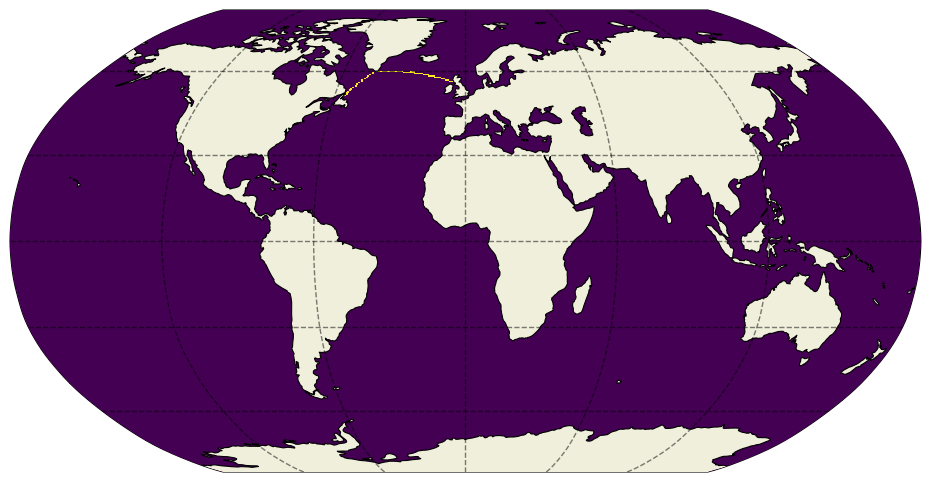

In [29]:
pt1_east = [-44, 60]
pt2_east = [-5, 56]

pt1_west = [-56, 51]
pt2_west = [-45, 60]

maskC_east, maskW_east, maskS_east = ecco.get_section_line_masks(pt1_east,pt2_east,ds)
maskC_west, maskW_west, maskS_west = ecco.get_section_line_masks(pt1_west,pt2_west,ds)
maskC_tot = (maskC_east+maskC_west).where(maskC_east+maskC_west==1,0)
maskW_tot = (maskW_east+maskW_west).where(np.abs(maskW_east)+np.abs(maskW_west)==1,0)
maskS_tot = (maskS_east+maskS_west).where(np.abs(maskS_east)+np.abs(maskS_west)==1,0)

plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0);

In [48]:
# Calculate volume transport in x and y direction
ds_out, sec_trsp_x, sec_trsp_y = volume_transport_calc(ds, maskS=maskS_tot, maskW=maskW_tot)

# Calculate total volume flux
ds_out["trsp_z"] = sec_trsp_y +sec_trsp_x

# Convert this to streamfunction
ds_out = calc_streamfunction_from_volume_transport(ds_out)
PSI = ds_out.compute()

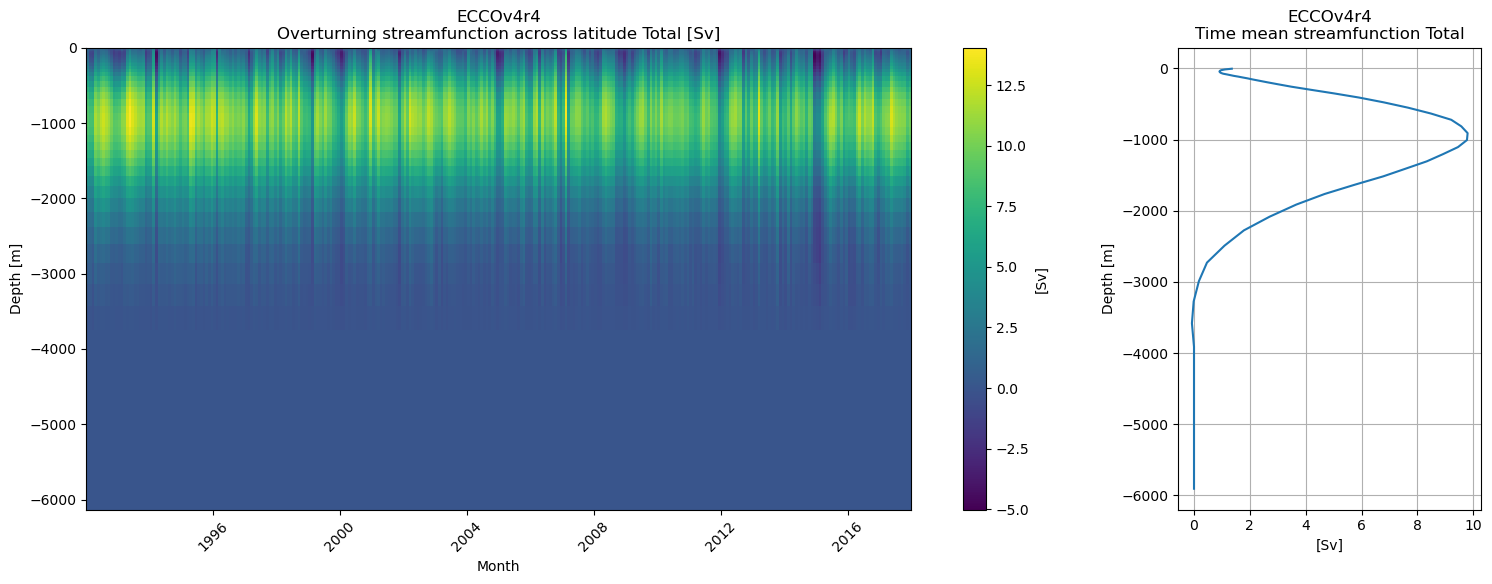

In [49]:
streamfunction.plot_depth_stf_vs_time(PSI,'Total', 'psi_moc')

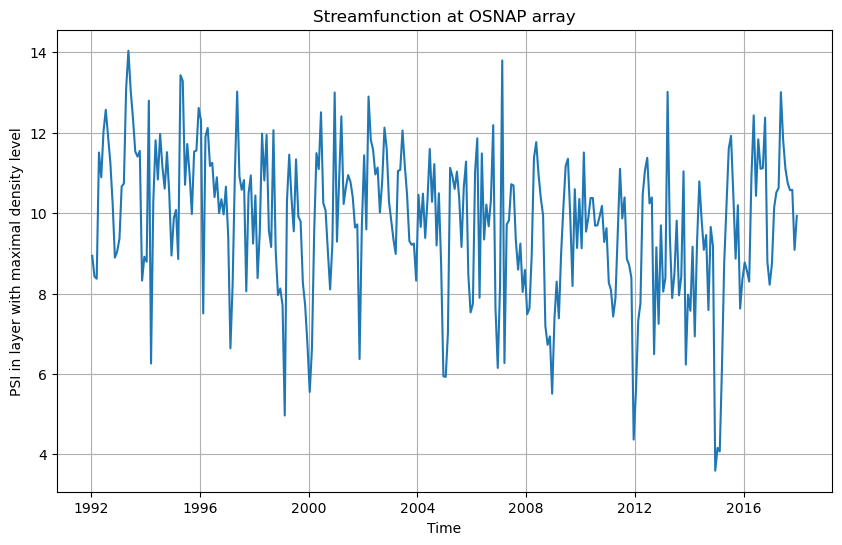

In [50]:
PSI_MAX_DENS = streamfunction.get_PSI_at_max_density_level(PSI, max=True)
streamfunction.plot_2D_streamfunction(PSI_MAX_DENS, f"Streamfunction at OSNAP array")

### LATITUDES GTC

#### 1. Utils for GTC calculations

In [7]:
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

In [6]:
def get_gridllc0090_mask(target_latitude, longitudes):

    FLIPPED_TILES = [7,8,9,10,11,12,13]
    
    # Split up the separate sections for the longitude list
    longitude_sections = np.split(longitudes, np.where(np.diff(longitudes) > 1)[0] + 1)
    
    # Create an empty mask
    mask = xr.DataArray(data=0, dims=ds['YC'].dims, coords=ds['YC'].coords)

    # Iterate over each "tile" of the grid 
    for tile_num in ds['tile'].values:

        if tile_num+1 in FLIPPED_TILES:
            latitude_dim = 'j'
        else:
            latitude_dim = 'i'

        tile_lats = ds['YC'].sel(tile=tile_num)
        tile_lons = ds['XC'].sel(tile=tile_num)
    
        tile_mask = abs(tile_lats - target_latitude) 
        zeros = xr.zeros_like(tile_mask)
    
        first_col = tile_lats.isel(**{latitude_dim: 0})
        lowest_lat = first_col.values.max()
        highest_lat = first_col.values.min()
    
        if max(lowest_lat, highest_lat) > target_latitude and min(lowest_lat, highest_lat) < target_latitude:
        
            row_to_mask = int(tile_mask.isel(**{latitude_dim: 0}).argmin().values)
        
            for longitude in longitude_sections:
                if tile_num+1 in FLIPPED_TILES:
                    column_mask = (tile_lons[:, row_to_mask] >= longitude[0]) & (tile_lons[:, row_to_mask] <= longitude[-1])
                    zeros.loc[column_mask, row_to_mask]= 1
                else:
                    column_mask = (tile_lons[row_to_mask, :] >= longitude[0]) & (tile_lons[row_to_mask,:] <= longitude[-1])
                    zeros.loc[row_to_mask, column_mask]= 1
    
        # Update the mask DataArray for the current face
        mask.loc[dict(tile=tile_num)] = zeros.astype(int)
    return mask

#### 2. Calculate for one specific latitude

In [12]:
# Use this to define which latitude and longitudes we are working at 
basin = 'southern'
latitudes = basin_masks.get_lats_of_interest_solodoch(basin)

# Parameter 'latitude' and 'longitudes' will be used to create the masks
latitude = -60
longitudes = basin_masks.get_longitudes_at_latitude(latitude, basin, geom_fp)

get_basin_name:  ['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents'] /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data
load_binary_array: loading file /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)


#### A. Original (ecco) system masks
Original way that the masks have been calculated -- output 26.5N and 30S seemed fine here (see section with outputs further on), but the masks don't seem to be fine on the map...

In [ ]:
from functools import reduce

masks_W = []
masks_S = [] 
masks_C = []

longitude_sections = np.split(longitudes, np.where(np.diff(longitudes) > 1)[0] + 1)

for section in longitude_sections:
    maskC, maskW, maskS = ecco.get_section_line_masks([0, latitude],[90, latitude], ds)
    masks_C.append(maskC)
    masks_W.append(maskW)
    masks_S.append(maskS)
    
maskC_tot = reduce(lambda x, y: x | y, masks_C)
maskSedge = reduce(lambda x, y: x | y, masks_S)
maskWedge = reduce(lambda x, y: x | y, masks_W)

plt.figure(figsize=(12,6))
#ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0);

#### B. New system to calculate the masks
The masks seem to be correct here (on the map) for any latitude and longitudes, but the calculations don't run (memory error) or not sure how to deal with the Wedge/Sedge?

(array([0, 1]), array([104940,    360]))


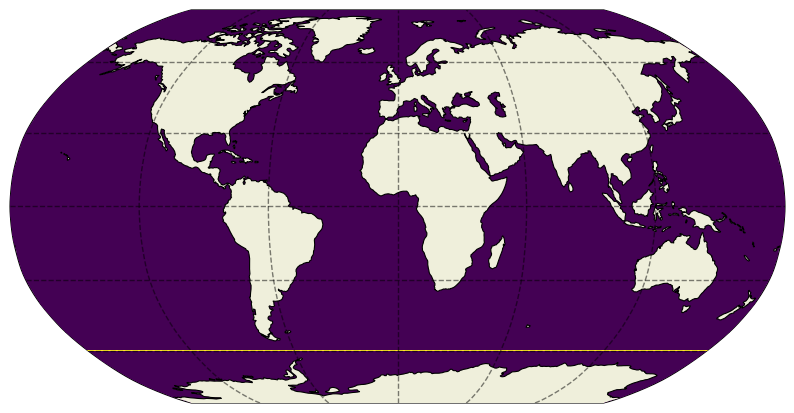

In [69]:
mask = get_gridllc0090_mask(latitude, longitudes)
print(np.unique(mask.values, return_counts=True))

plt.figure(figsize=(10,10))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,mask,cmap='viridis',projection_type='robin',user_lon_0=0);

In [70]:
velocity = ds['VVELMASS'].isel(time = 0)
delta_x = ds['dxG']
delta_z = ds['drF']

weighted_velocity = velocity * delta_x * delta_z

In [71]:
mask = mask.rename({'j' : 'j_g'}) 
weighted_velocity_at_lat = mask * weighted_velocity

weighted_velocity_at_lat

<xarray.DataArray (tile: 13, j_g: 90, i: 90, k: 50)>
dask.array<multiply, shape=(13, 90, 90, 50), dtype=float64, chunksize=(13, 90, 90, 50), chunktype=numpy.ndarray>
Coordinates:
    YC       (tile, j_g, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    XC       (tile, j_g, i) float32 -111.6 -111.3 -110.9 ... -105.6 -111.9
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    Z        (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-01-16T18:00:00

In [220]:
lon_by_depth = []

for i in range(13):    
    arr = weighted_velocity_at_lat.isel(tile = i).fillna(0).values
    nonzero_ind = np.nonzero(arr)

    unique_vals = np.unique(nonzero_ind[0]), np.unique(nonzero_ind[1])
    if len(unique_vals[0]) == 1:
        nonzero_vals = arr[unique_vals[0][0], : , : ]
    elif len(unique_vals[1]) == 1:
        nonzero_vals = arr[ : , unique_vals[1][0], : ]
    else:
        print('No nonzero vals')
        continue

    print(nonzero_vals.shape)
    lon_by_depth.append(nonzero_vals)

(90, 50)
No nonzero vals
No nonzero vals
(90, 50)
No nonzero vals
No nonzero vals
No nonzero vals
No nonzero vals
No nonzero vals
(90, 50)
No nonzero vals
No nonzero vals
(90, 50)


In [221]:
lon_by_depth = np.concatenate(lon_by_depth, axis = 0)
lon_by_depth.shape

(360, 50)

Streamfunction is -830 Sverdrups


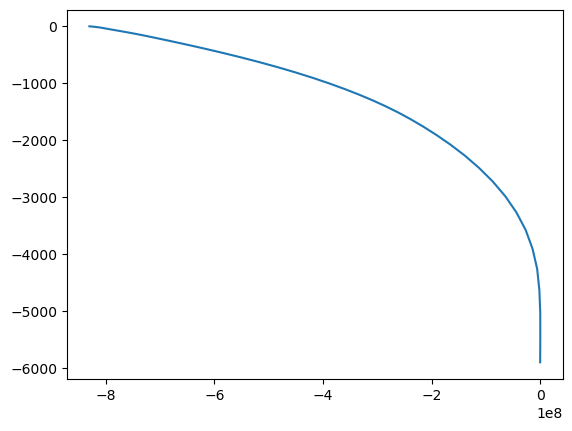

In [248]:
streamfunction = -1 * lon_by_depth.sum(axis = 0)[ : : -1].cumsum()
depth_level = np.abs(streamfunction).argmax()
print(f'Streamfunction is {round(streamfunction[depth_level] / (10 ** 6))} Sverdrups')

plt.plot(streamfunction, delta_z.Z[ : : -1]);

### Trying out janky function

In [9]:
from importlib import reload
reload(streamfunction)

<module 'streamfunction' from '/Users/emiliolr/Desktop/GTC-OTP/streamfunction.py'>

In [ ]:
strf_vals = []
for t in [i for i in range(10)]:
    strf_vals.append(streamfunction.calculate_streamfunction_JANKY(ds, basin = 'southern', latitude = -60, time = t, geom_fp = geom_fp))

In [12]:
strf_vals

[-830, -661, -696, -760, -687, -643, -811, -823, -819, -850]

### Alternative: using the latitudinal streamfunction function in `ecco`

In [24]:
# Calculate streamfunction over 60S and over all time periods
strf_60s = ecco.calc_meridional_stf(ds, [-60], doFlip = True, basin_name = None)

In [54]:
strf_60s

<xarray.Dataset>
Dimensions:  (k: 50, lat: 1, time: 312)
Coordinates:
    Z        (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) int64 -60
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    trsp_z   (time, k, lat) float64 5.036 3.815 2.224 ... -0.3735 0.1162 0.0
    psi_moc  (time, k, lat) float64 1.463 6.499 10.31 ... 0.2573 -0.1162 0.0
    moc      (time, lat) float64 13.15 8.19 13.12 18.9 ... 17.0 23.34 14.69

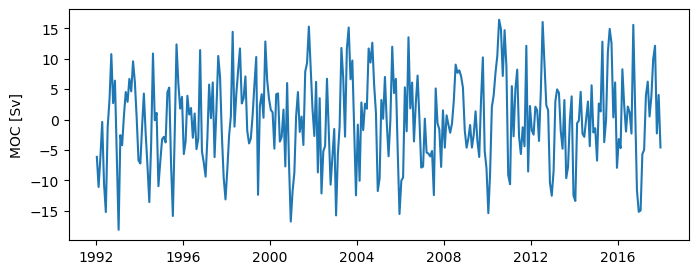

In [58]:
# Plot overturning streamfunction over time
plt.figure(figsize = (8, 3))
plt.plot(strf_60s.time, strf_60s.moc - strf_60s.moc.mean(dim = 'time'))

plt.ylabel('MOC [Sv]');

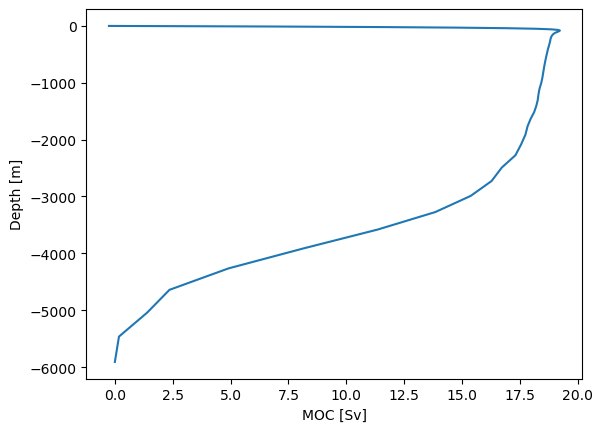

In [59]:
# Plot average streamfunction over depth space
plt.plot(strf_60s.psi_moc.mean(dim = 'time'), strf_60s.Z)

plt.xlabel('MOC [Sv]')
plt.ylabel('Depth [m]');

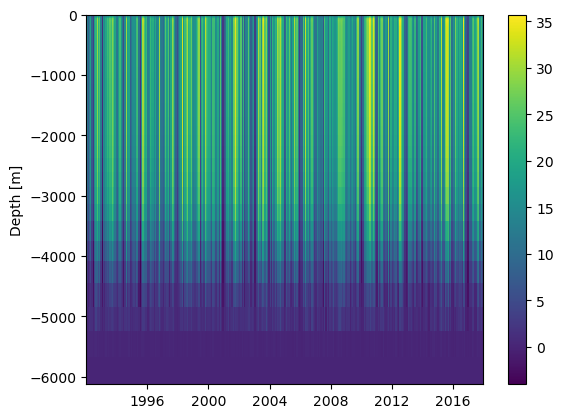

In [60]:
# Streamfunction over depth and time
plt.pcolormesh(strf_60s.time, strf_60s.Z, strf_60s.psi_moc.squeeze().T)
plt.colorbar()

plt.ylabel('Depth [m]');

### Strange stuff that isn't working...

In [70]:
# DO WE NEED TO SPLIT A maskWedge and maskSedge, if not, how to use the general mask? 

grid = ecco.ecco_utils.get_llc_grid(ds)
maskWedge = grid.diff(mask, 'X', boundary='fill')
maskSedge = grid.diff(mask, 'X', boundary='fill')
print(np.unique(maskWedge.values, return_counts=True))
print(np.unique(maskSedge.values, return_counts=True))

(array([-1,  0,  1]), array([   137, 105026,    137], dtype=int64))
(array([-1,  0,  1]), array([   137, 105026,    137], dtype=int64))


In [45]:
# Calculate volume transport in x and y direction
ds_out, sec_trsp_x, sec_trsp_y = volume_transport_calc(ds, maskS=maskSedge, maskW=maskWedge)

# Calculate total volume flux
ds_out["trsp_z"] = sec_trsp_y + sec_trsp_x

# Convert this to streamfunction
ds_out = calc_streamfunction_from_volume_transport(ds_out)
PSI = ds_out.compute()

MemoryError: Unable to allocate 6.35 GiB for an array with shape (1, 1, 13, 90, 90, 90, 90) and data type float64

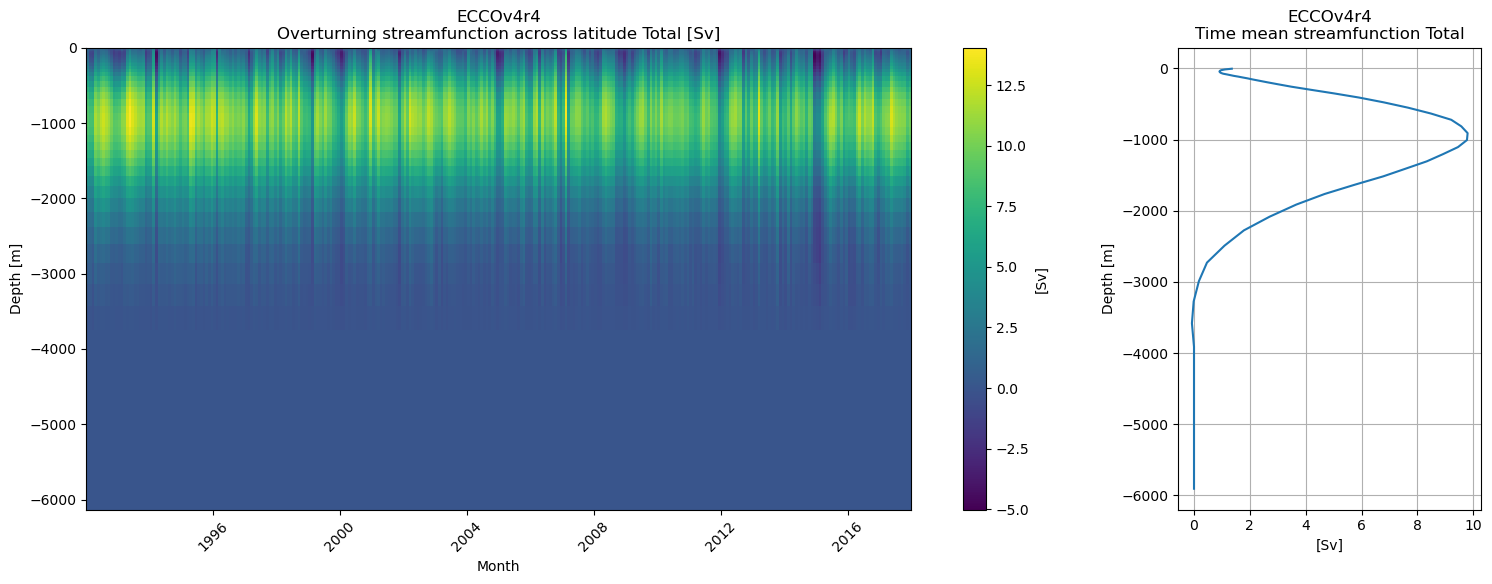

In [28]:
streamfunction.plot_depth_stf_vs_time(PSI,'Total', 'psi_moc')

## Open the output files so far to plot the streamfunctions

In [71]:
OUTPUT_DIR = os.path.join(DIR, "GTC/streamfunctions_ecco")

In [72]:
PSI_26 = xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_26.5N.nc"))
PSI_30 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S.nc"))
PSI_30_0 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S_section_0.nc"))
PSI_30_1 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S_section_1.nc"))
PSI_30_2 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S_section_2.nc"))
PSI_60 = xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_60S.nc"))
PSI_55 = xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_55S.nc"))

Streamfunction at 26.5N looked fine in the way it was calculated (ecco.get_section_line_mask(pt1, pt2, ds); even if the mask wasn't correct the streamfunction calculated from there did look okay... (using trsp_x and trsp_y)

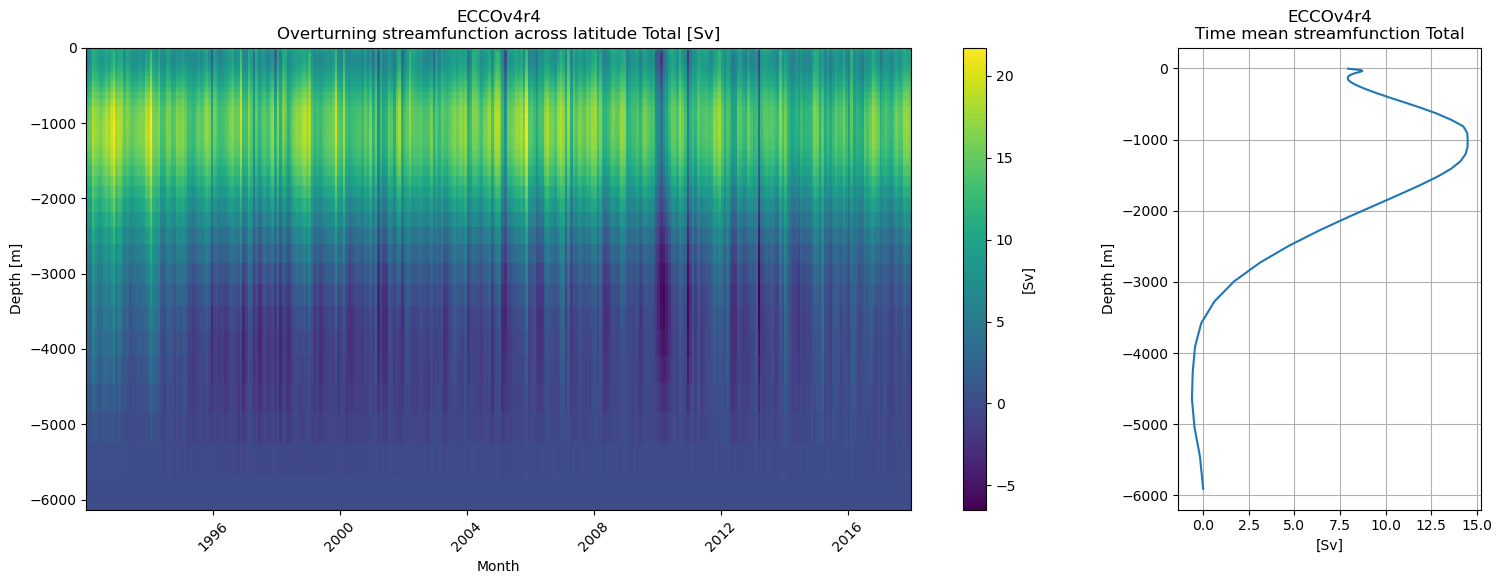

In [73]:
streamfunction.plot_depth_stf_vs_time(PSI_26,'Total', 'psi_moc')

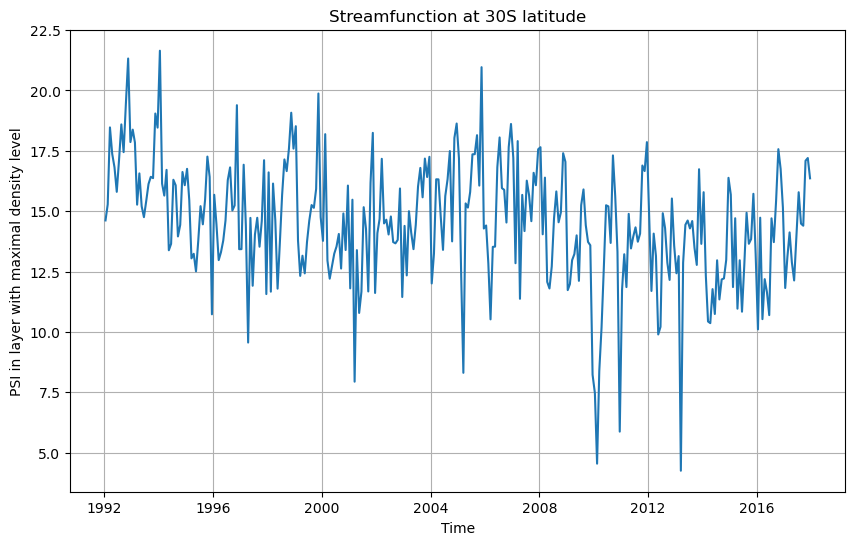

In [74]:
PSI_MAX_DENS = streamfunction.get_PSI_at_max_density_level(PSI_26, max=True)
streamfunction.plot_2D_streamfunction(PSI_MAX_DENS, f"Streamfunction at {format_lat_lon(latitude)} latitude")